In [1]:
cd ..

/home/msi/projects/diplomka


In [2]:
import pandas as pd

In [3]:
!ls data/sites/

AGLT2-CSCS_LCG2      GLOW-CSCS_LCG2	Nebraska-CSCS_LCG2
BNL_ATLAS-CSCS_LCG2  INFN-T1		SARA_MATRIX-CSCS_LCG2
CA_SFU_T2-CSCS_LCG2  INFN_T1-CSCS_LCG2
FZK_LCCG2-INFN_T1    NDGF_T1-CSCS_LCG2


In [4]:
import glob

In [228]:
files = sorted(glob.glob('data/sites/SARA_MATRIX-CSCS_LCG2/*.json'))

In [229]:
import json

In [230]:
with open(files[18689], 'r') as f:
    data = json.load(f)

In [231]:
data

{'max_rtt': 83.2,
 'src_VO': 'ATLAS',
 'created_at': '2023-02-03T15:23:47.009342173Z',
 'dest': '148.187.129.15',
 'src_site': 'SARA-MATRIX',
 'path_complete': True,
 'MA': '145.100.32.31',
 'destination_reached': True,
 'ipv6': False,
 'dest_production': True,
 'asns': [1103,
  0,
  0,
  0,
  1103,
  1103,
  513,
  20965,
  20965,
  20965,
  20965,
  559,
  559,
  559],
 'n_hops': 14,
 'timestamp': 1675436493000,
 'src': '145.100.32.31',
 'dest_site': 'CSCS-LCG2',
 'dest_VO': 'ATLAS',
 'looping': False,
 'src_host': 'perfsonar-latency.grid.surfsara.nl',
 'push': False,
 'route-sha1': '1d0679f8c121afb9b4407ad9be0e99fd61b8bfbb',
 'ttls': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 'rtts': [0.1,
  0.2,
  0.2,
  0.1,
  0.7,
  0.4,
  6.7,
  0.6,
  37.699999999999996,
  15.6,
  16.5,
  21.8,
  83.2,
  19.400000000000002],
 'dest_host': 'perfsonar01.lcg.cscs.ch',
 'hops': ['145.100.32.1',
  '172.16.208.10',
  '172.16.208.89',
  '172.16.208.7',
  '145.100.0.157',
  '145.145.34.49',
  '1

In [232]:
data.keys()

dict_keys(['max_rtt', 'src_VO', 'created_at', 'dest', 'src_site', 'path_complete', 'MA', 'destination_reached', 'ipv6', 'dest_production', 'asns', 'n_hops', 'timestamp', 'src', 'dest_site', 'dest_VO', 'looping', 'src_host', 'push', 'route-sha1', 'ttls', 'rtts', 'dest_host', 'hops', 'src_production'])

In [233]:
data['asns']

[1103, 0, 0, 0, 1103, 1103, 513, 20965, 20965, 20965, 20965, 559, 559, 559]

In [234]:
from collections import defaultdict

In [235]:
import numpy as np

In [236]:
from hashlib import sha1

In [237]:
def remove_duplicates(values):
    deduped = []
    initial = values[0]
    for value in values[1:]:
        if value != initial:
            deduped.append(value)
            initial = value
    return deduped

In [238]:
def get_hash(values):
    return sha1(
            str(values).encode('utf-8')
        ).hexdigest()[-8:]

In [239]:
asn_transition_probs = defaultdict(lambda: defaultdict(lambda: 0))
asn_ip_prob = defaultdict(lambda: defaultdict(lambda: 0))

In [240]:
from traced_v2.models.poisson import PoissonModel

In [241]:
n_hops_model = PoissonModel("src", "dest") 

In [242]:
from traced.models.bernoulli_model import BernoulliModel

In [243]:
reached = BernoulliModel("src", "dest")

In [244]:
path_complete = BernoulliModel("src", "dest")

In [245]:
asn_probs = []
ip_probs = []
timestamps = []
n_hops = []

asn_hashes = []
uniq_asn_hashes = []
asn_error = []

for file in files:
    with open(file, 'r') as f:
        data = json.load(f)
    n_hops_model.log(data['timestamp'], len(data['hops']))    
    if not ('asns' in data and data['asns'] and 'hops' in data and data['hops']): 
        continue
    
    reached.log(data['timestamp'], data['destination_reached'])    
    path_complete.log(data['timestamp'], data['path_complete'])    
    
    timestamps.append(data['timestamp'])
    n_hops.append(len(data['hops']))
    current_asn = -1
    
    _asn_probs = []
    _ip_probs = []
    _mixed_probs = []
    
    for asn, ip in zip(data['asns'], data['hops']):
        _asn_probs.append(asn_transition_probs[current_asn][asn] / (1+sum(asn_transition_probs[current_asn].values())))
        asn_transition_probs[current_asn][asn] += 1
        _ip_probs.append(asn_ip_prob[asn][ip] / (1+sum(asn_ip_prob[asn].values())))
        asn_ip_prob[asn][ip] += 1
        current_asn = asn
        
    asn_probs.append(_asn_probs)
    ip_probs.append(_ip_probs)
    
    asn_hashes.append(get_hash(data['asns']))
    uniq_asn_hashes.append(get_hash(remove_duplicates(data['asns'])))
    

In [246]:
timestamps = pd.to_datetime(timestamps, unit='ms')

In [247]:
final = np.hstack([np.mean(np.array(asn_probs[i]) * np.array(ip_probs[i])).T for i in range(len(ip_probs))])

In [248]:
K = np.hstack([np.log1p(np.mean(np.array(x)))for x in ip_probs])

In [249]:
L = np.hstack([np.exp(-np.linalg.norm(np.array(x)))for x in asn_probs])

In [250]:
K

array([0.        , 0.        , 0.12413948, ..., 0.20382802, 0.20379815,
       0.2038002 ])

In [251]:
T = pd.DataFrame(
    {'asn_prop_t':K.flatten(), 'ip_prob': L.flatten() , 'asn_hash': asn_hashes, 'uniq_asns': uniq_asn_hashes,'final':final, 'timestamp': pd.to_datetime(timestamps, unit='ms')})

In [252]:
T['final_diff'] = T['final'].diff()

In [253]:
T['asn_prop_diff'] = T['asn_prop_t'].diff()

In [254]:
# T.plot(backend='plotly', y='asn_prop_t', x='timestamp', kind='scatter', color='asn_hash')

In [255]:
grouped = T.groupby('asn_hash')

In [256]:
models = {}

In [257]:
from traced_v2.models.normal import NormalModel

In [258]:
for i, x in grouped.groups.items():
    trace = T[T['asn_hash']==i].set_index('timestamp').sort_index()
    models[i] = NormalModel("src", "dest", one_sided=False, sigma_0=0, mu_0=0.3, sigma_factor=3, gamma=1)
    for j, val in trace[('asn_prop_t')].items():
        models[i].log(j.timestamp()*1000, np.exp(val))
        
    

In [259]:
import matplotlib.pyplot as plt



In [260]:
# for m in models.values():
#     fig = plt.figure()
#     m.plot()
#     fig.show()

In [261]:
T[T['asn_hash']=='303fd16d'].sort_values('timestamp')


Empty DataFrame
Columns: [asn_prop_t, ip_prob, asn_hash, uniq_asns, final, timestamp, final_diff, asn_prop_diff]
Index: []

In [262]:
import matplotlib.pyplot as plt
from math import prod

In [263]:
final = np.hstack([-np.log1p(np.mean(np.array(asn_probs[i]))).T for i in range(len(ip_probs))])

In [264]:
final2 = np.stack([np.sum(x)] for x in asn_probs)

/home/msi/miniconda3/envs/stats/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


In [265]:
np.where(final > -.5)[0]

array([    0,     1,     2, ..., 56792, 56832, 57331])

In [266]:
uniqs = np.unique(uniq_asn_hashes)

In [267]:
cmap = plt.cm.viridis

In [268]:
uniqs

array(['2a97674c', '31c21f2e', '343aa8cc', '4c7cc3cc', '58b0e439',
       '5eaf9a86', 'a6234064', 'aa42ff6c', 'cca4c746', 'dc0cea63'],
      dtype='<U8')

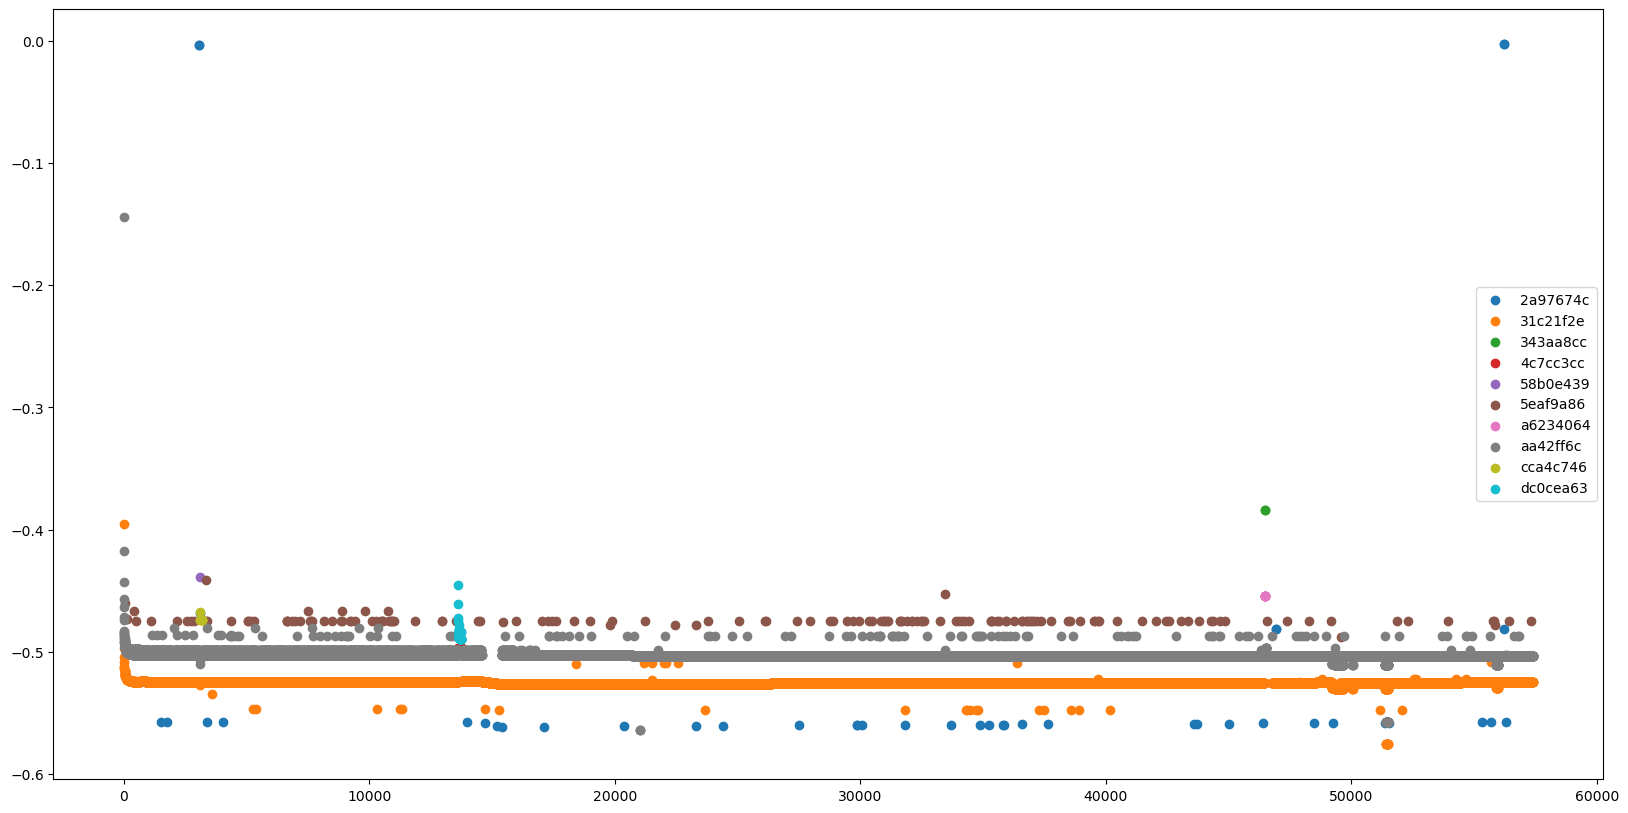

In [269]:
index = np.arange(final.shape[0])
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)

for i, u in enumerate(uniqs):
    sub_index = np.where(np.array(uniq_asn_hashes)==u)
    ax.scatter(index[sub_index], final[sub_index], label=u)
plt.legend()


<Axes: >

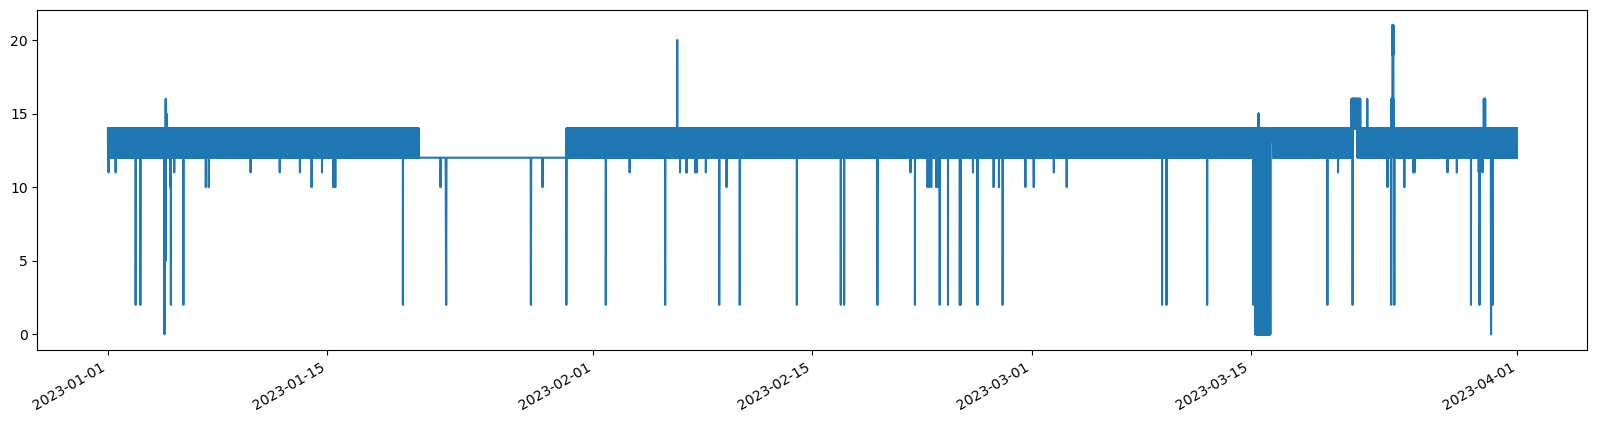

In [270]:
fig = plt.figure(figsize=(20, 5))
ax =  fig.gca()
nh = n_hops_model.to_frame()
nh['observed_values'].plot(ax=ax) 

In [271]:
nh

observed_values  expected_values  probabilities  \
2023-01-01 00:00:05               14         7.500000       0.011304   
2023-01-01 00:00:30               12         9.000000       0.072765   
2023-01-01 00:02:18               14        10.250000       0.057307   
2023-01-01 00:02:46               14        11.000000       0.072753   
2023-01-01 00:06:08               14        11.500000       0.082220   
...                              ...              ...            ...   
2023-03-31 23:54:58               12        13.318117       0.106904   
2023-03-31 23:55:45               14        13.318129       0.104185   
2023-03-31 23:55:51               14        13.318141       0.104185   
2023-03-31 23:59:19               14        13.318153       0.104185   
2023-03-31 23:59:45               14        13.318164       0.104186   

                     anomalies  
2023-01-01 00:00:05       True  
2023-01-01 00:00:30      False  
2023-01-01 00:02:18      False  
2023-01-01 00:02:46      False  
2023-01-01 00:06:08      False  
...                        ...  
2023-03-31 23:54:58      False  
2023-03-31 23:55:45      False  
2023-03-31 23:55:51      False  
2023-03-31 23:59:19      False  
2023-03-31 23:59:45      False  

[57551 rows x 4 columns]

(-0.05, 1.0)

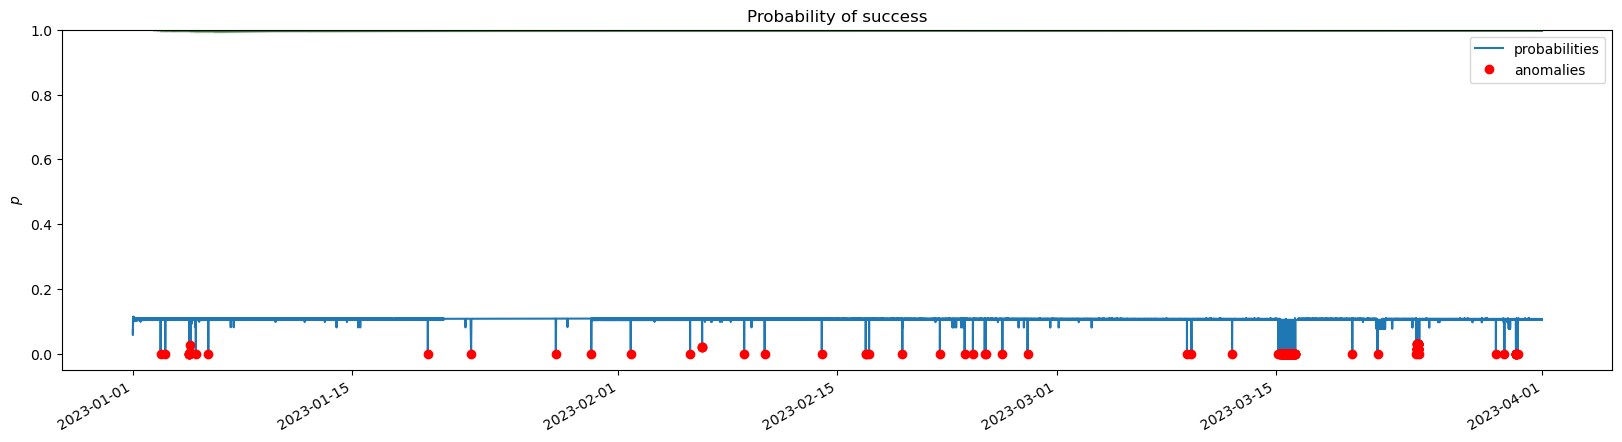

In [272]:
fig = plt.figure(figsize=(20, 5))
ax =  fig.gca()
n_hops_model.plot(ax=ax)
# path_complete.plot(ax=ax)
reached.plot(ax=ax)
ax.set_ylim(-0.05, 1 )


In [273]:
for i, x in {'asn': asn_hashes, 'uniq_asn': uniq_asn_hashes, 'n_hops_prob': n_hops_model.probs[1:], 'dest_reach_prob': reached.success_probs[1:], 'path_complete_prob': path_complete.success_probs[1:], 'final':final[1:], 'timestamp': timestamps}.items():
    print(i, len(x))

asn 57406
uniq_asn 57406
n_hops_prob 57551
dest_reach_prob 57406
path_complete_prob 57406
final 57405
timestamp 57406


In [274]:
df = pd.DataFrame({'asn': asn_hashes, 'uniq_asn': uniq_asn_hashes, 'n_hops_prob': n_hops_model.probs[1:], 'dest_reach_prob': reached.success_probs[1:], 'path_complete_prob': path_complete.success_probs[1:], 'final':final, 'timestamp': timestamps})

ValueError: All arrays must be of the same length

In [ ]:
df['asn'] = df['asn'].astype('category')
df['uniq_asn'] = df['uniq_asn'].astype('category')
# df.set_index('timestamp', inplace=True)

In [ ]:
df

asn  uniq_asn  n_hops_prob  dest_reach_prob  path_complete_prob  \
0      06d04b68  d82537d6     0.009026         1.000000                 0.0   
1      bfd6fad5  5660cdf5     0.031287         1.000000                 0.0   
2      026c3b42  d82537d6     0.054293         1.000000                 0.0   
3      026c3b42  d82537d6     0.068513         1.000000                 0.0   
4      026c3b42  d82537d6     0.077234         1.000000                 0.0   
...         ...       ...          ...              ...                 ...   
98240  b9da51a1  b8ba857a     0.033009         0.998555                 0.0   
98241  c92d58f3  50246e69     0.095732         0.998555                 0.0   
98242  c92d58f3  50246e69     0.095732         0.998555                 0.0   
98243  b9da51a1  b8ba857a     0.033010         0.998555                 0.0   
98244  c92d58f3  50246e69     0.095731         0.998555                 0.0   

          final           timestamp  
0     -0.177681 2023-01-01 00:00:19  
1     -0.399961 2023-01-01 00:00:55  
2     -0.450756 2023-01-01 00:02:18  
3     -0.479445 2023-01-01 00:02:20  
4     -0.495144 2023-01-01 00:08:52  
...         ...                 ...  
98240 -0.423164 2023-03-31 23:57:02  
98241 -0.519717 2023-03-31 23:58:16  
98242 -0.519717 2023-03-31 23:58:31  
98243 -0.423165 2023-03-31 23:59:40  
98244 -0.519717 2023-03-31 23:59:46  

[98245 rows x 7 columns]

In [ ]:
df.columns

Index(['asn', 'uniq_asn', 'n_hops_prob', 'dest_reach_prob',
       'path_complete_prob', 'final', 'timestamp'],
      dtype='object')

ValueError: There are 62 color bins including extensions, but ncolors = 20; ncolors must equal or exceed the number of bins

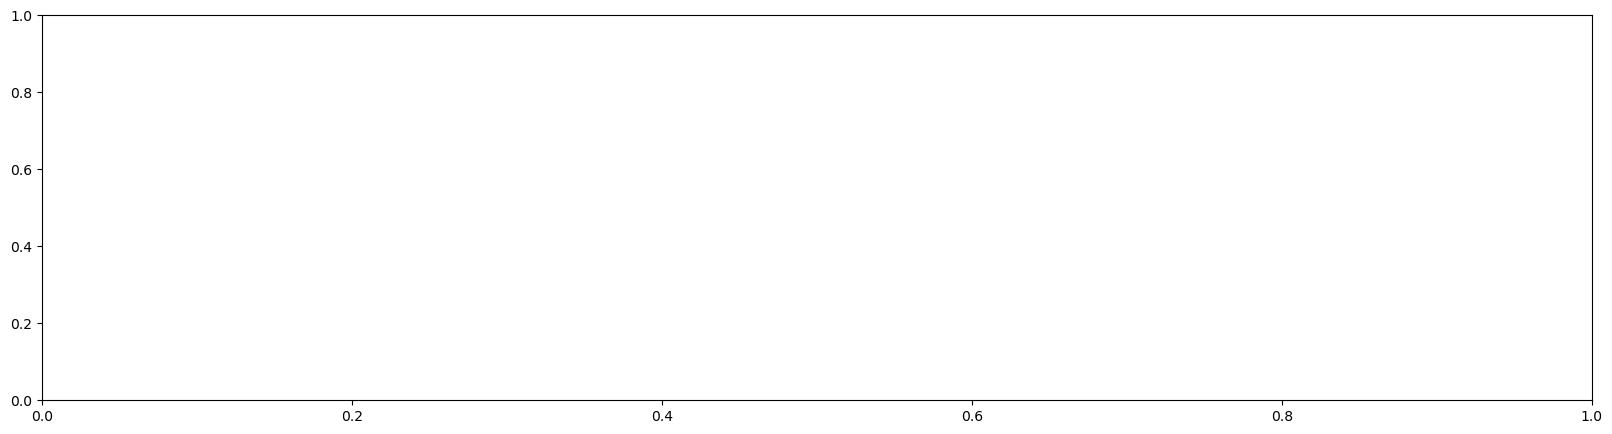

In [ ]:
# df.plot(backend='matplotlib', y=['n_hops_prob', 'dest_reach_prob', 'path_complete_prob'], x='timestamp', kind='scatter', color='asn')
fig = plt.figure(figsize=(20,5))
ax = plt.gca()
df.plot(backend='matplotlib', y='dest_reach_prob', x='timestamp', kind='scatter', c='uniq_asn', cmap='tab20_r', ax=ax, alpha=0.5)

<Axes: xlabel='timestamp', ylabel='final'>

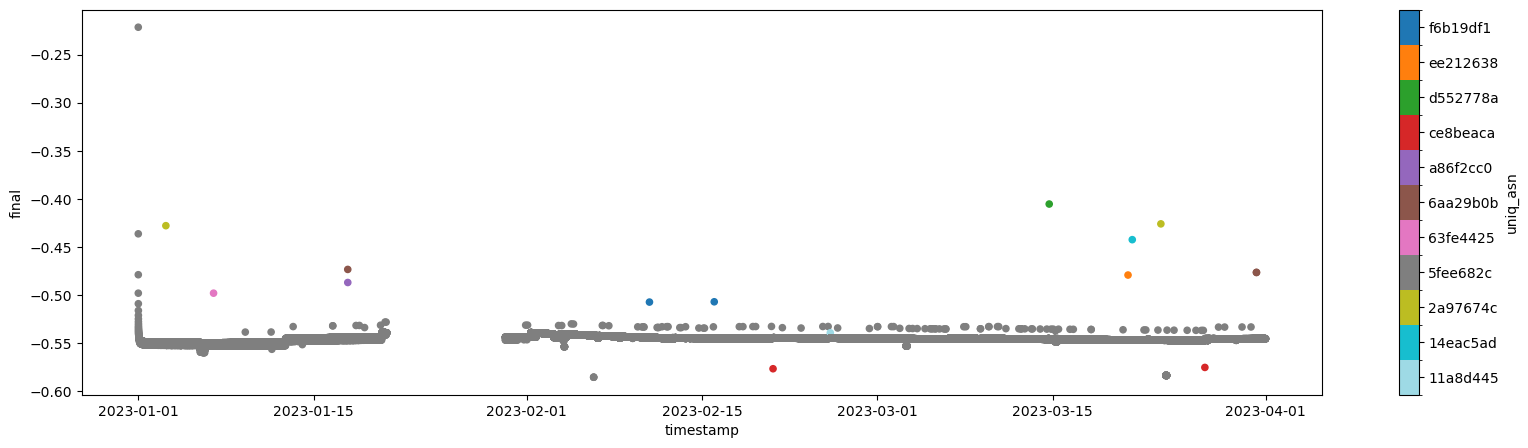

In [ ]:
# df.plot(backend='matplotlib', y=['n_hops_prob', 'dest_reach_prob', 'path_complete_prob'], x='timestamp', kind='scatter', color='asn')
fig = plt.figure(figsize=(20,5))
ax = plt.gca()
df.plot(backend='matplotlib', y='final', x='timestamp', kind='scatter', c='uniq_asn', cmap='tab20_r', ax=ax)

<Axes: xlabel='timestamp', ylabel='path_complete_prob'>

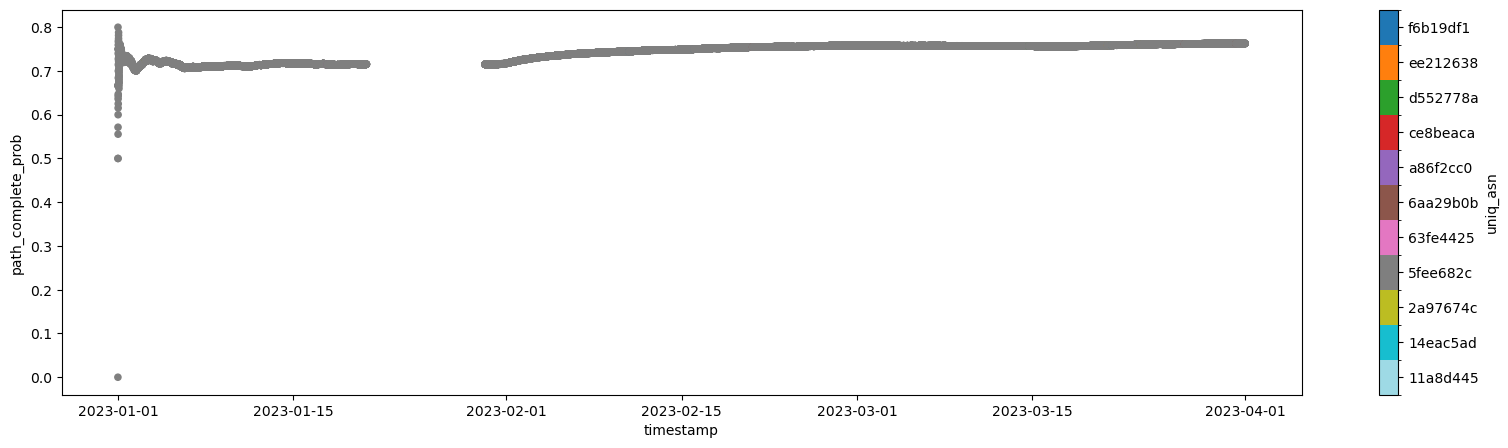

In [ ]:
# df.plot(backend='matplotlib', y=['n_hops_prob', 'dest_reach_prob', 'path_complete_prob'], x='timestamp', kind='scatter', color='asn')
fig = plt.figure(figsize=(20,5))
ax = plt.gca()
df.plot(backend='matplotlib', y= 'path_complete_prob', x='timestamp', kind='scatter', c='uniq_asn', cmap='tab20_r', ax=ax)

<Axes: xlabel='n_hops_prob', ylabel='final'>

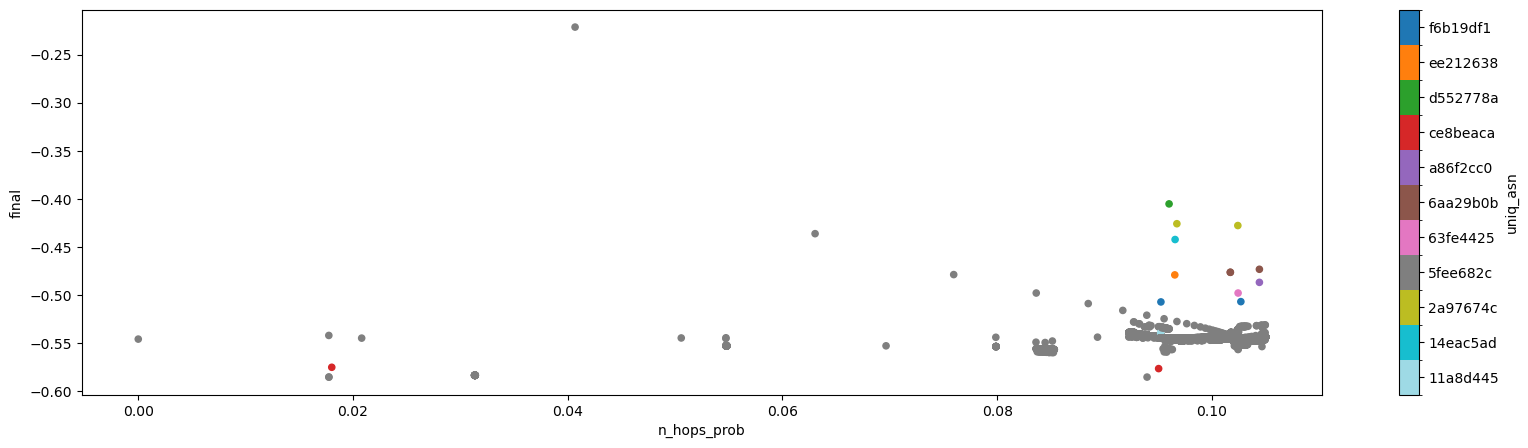

In [ ]:
# df.plot(backend='matplotlib', y=['n_hops_prob', 'dest_reach_prob', 'path_complete_prob'], x='timestamp', kind='scatter', color='asn')
fig = plt.figure(figsize=(20,5))
ax = plt.gca()
df.plot(backend='matplotlib', y= 'final', x='n_hops_prob', kind='scatter', c='uniq_asn', cmap='tab20_r', ax=ax)

In [ ]:
from traced_v2.models.multinomial import MultinomialModel

In [ ]:
mm = MultinomialModel("src", "dest")


In [ ]:
df

asn  uniq_asn  n_hops_prob  dest_reach_prob  path_complete_prob  \
0      9aab4691  5fee682c     0.040682         1.000000            0.000000   
1      9aab4691  5fee682c     0.063035         1.000000            0.500000   
2      9aab4691  5fee682c     0.075946         1.000000            0.666667   
3      9aab4691  5fee682c     0.083632         1.000000            0.750000   
4      9aab4691  5fee682c     0.088475         1.000000            0.800000   
...         ...       ...          ...              ...                 ...   
44629  73e95713  5fee682c     0.101781         0.997535            0.762873   
44630  73e95713  5fee682c     0.101781         0.997535            0.762878   
44631  73e95713  5fee682c     0.101781         0.997535            0.762883   
44632  73e95713  5fee682c     0.101781         0.997535            0.762888   
44633  73e95713  5fee682c     0.101781         0.997536            0.762894   

          final           timestamp  
0     -0.221364 2023-01-01 00:01:53  
1     -0.436544 2023-01-01 00:03:53  
2     -0.479159 2023-01-01 00:05:20  
3     -0.498362 2023-01-01 00:06:10  
4     -0.509348 2023-01-01 00:11:10  
...         ...                 ...  
44629 -0.545813 2023-03-31 23:45:44  
44630 -0.545813 2023-03-31 23:53:16  
44631 -0.545813 2023-03-31 23:53:37  
44632 -0.545813 2023-03-31 23:56:51  
44633 -0.545813 2023-03-31 23:57:02  

[44634 rows x 7 columns]

In [ ]:

mm = MultinomialModel("src", "dest")

for i, x in df.set_index('timestamp')['uniq_asn'].items():
    mm.log(i.timestamp()*1000, x)    

In [ ]:
mm.category_probs

{'5fee682c': 0.9994400394212247,
 '2a97674c': 0.00010012515644555694,
 '63fe4425': 0.0008748906386701663,
 '6aa29b0b': 0.00011299690388483356,
 'a86f2cc0': 0.00031575623618566466,
 'f6b19df1': 0.00019527436047646945,
 'ce8beaca': 9.537889265105632e-05,
 '11a8d445': 0.00011738926279542965,
 'd552778a': 8.56800137088022e-05,
 'ee212638': 7.797270955165692e-05,
 '14eac5ad': 7.757951900698215e-05}

In [ ]:
df['uniq_asn_prob'] = df['uniq_asn'].apply(mm.category_probs.__getitem__)

In [ ]:
df['uniq_asn_prob']

0        0.99944
1        0.99944
2        0.99944
3        0.99944
4        0.99944
          ...   
44629    0.99944
44630    0.99944
44631    0.99944
44632    0.99944
44633    0.99944
Name: uniq_asn_prob, Length: 44634, dtype: category
Categories (11, float64): [0.000117, 0.000078, 0.000100, 0.999440, ..., 0.000095, 0.000086, 0.000078, 0.000195]

In [ ]:

mm = MultinomialModel("src", "dest")

for i, x in df.set_index('timestamp')['asn'].items():
    mm.log(i.timestamp()*1000, x)    

In [ ]:
df['asn_prob'] = df['asn'].apply(mm.category_probs.__getitem__)

In [ ]:
df['asn_prob']

0        0.167844
1        0.167844
2        0.167844
3        0.167844
4        0.167844
           ...   
44629    0.361662
44630    0.361662
44631    0.361662
44632    0.361662
44633    0.361662
Name: asn_prob, Length: 44634, dtype: category
Categories (31, float64): [0.484443, 0.000078, 0.000874, 0.000104, ..., 0.000329, 0.000146, 0.000172, 0.000075]

03e7eeb8  48.444%


n_hops_prob  dest_reach_prob  path_complete_prob     final
n_hops_prob            1.000000        -0.621642            0.643059 -0.693854
dest_reach_prob       -0.621642         1.000000           -0.871279  0.912253
path_complete_prob     0.643059        -0.871279            1.000000 -0.960880
final                 -0.693854         0.912253           -0.960880  1.000000

/home/msi/miniconda3/envs/stats/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1258: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


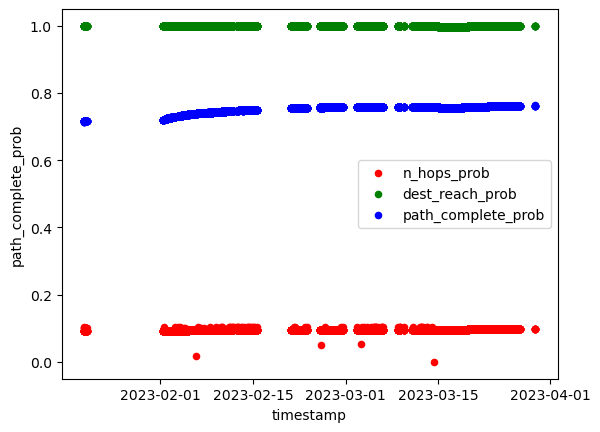

2dc2be9d  0.169%


n_hops_prob  dest_reach_prob  path_complete_prob     final
n_hops_prob            1.000000         0.181504            0.023930 -0.157756
dest_reach_prob        0.181504         1.000000           -0.379673  0.344697
path_complete_prob     0.023930        -0.379673            1.000000 -0.232156
final                 -0.157756         0.344697           -0.232156  1.000000

/home/msi/miniconda3/envs/stats/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1258: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


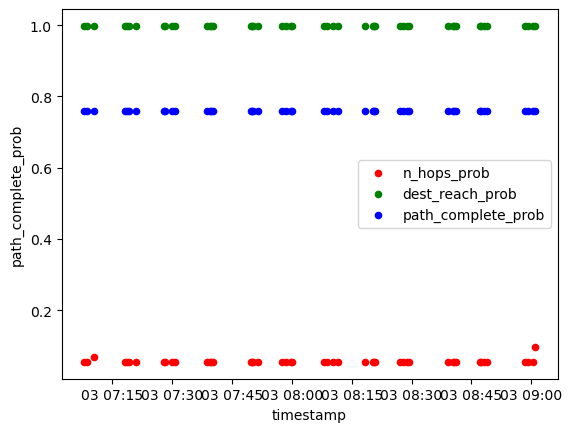

306df33e  0.014%


n_hops_prob  dest_reach_prob  path_complete_prob     final
n_hops_prob            1.000000         0.681019           -0.643129 -0.682061
dest_reach_prob        0.681019         1.000000           -0.998721 -0.999999
path_complete_prob    -0.643129        -0.998721            1.000000  0.998648
final                 -0.682061        -0.999999            0.998648  1.000000

/home/msi/miniconda3/envs/stats/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1258: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


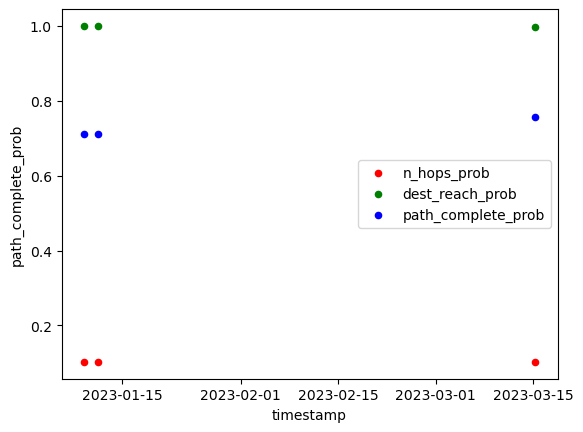

41a20a4f  9.337%


n_hops_prob  dest_reach_prob  path_complete_prob     final
n_hops_prob            1.000000        -0.018001            0.053851 -0.094183
dest_reach_prob       -0.018001         1.000000            0.186820  0.241677
path_complete_prob     0.053851         0.186820            1.000000  0.617304
final                 -0.094183         0.241677            0.617304  1.000000

/home/msi/miniconda3/envs/stats/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1258: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


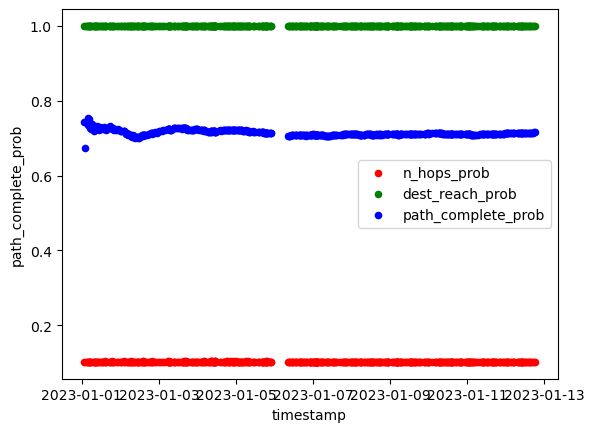

55d88fac  0.089%


n_hops_prob  dest_reach_prob  path_complete_prob     final
n_hops_prob            1.000000         0.628921           -0.532153  0.607576
dest_reach_prob        0.628921         1.000000           -0.947926  0.781819
path_complete_prob    -0.532153        -0.947926            1.000000 -0.863690
final                  0.607576         0.781819           -0.863690  1.000000

/home/msi/miniconda3/envs/stats/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1258: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


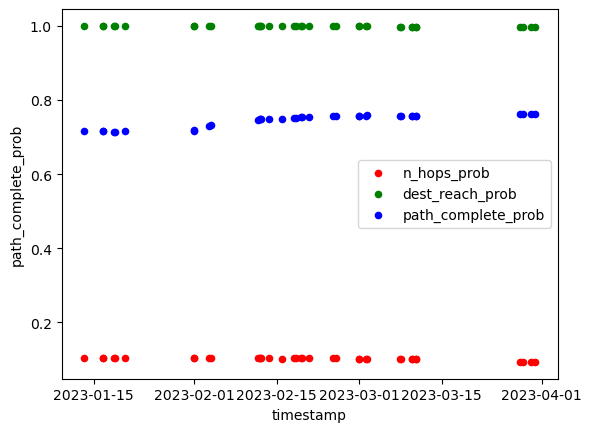

5e4b7feb  1.060%


n_hops_prob  dest_reach_prob  path_complete_prob     final
n_hops_prob            1.000000         0.168332           -0.380915 -0.013882
dest_reach_prob        0.168332         1.000000           -0.753151 -0.929937
path_complete_prob    -0.380915        -0.753151            1.000000  0.599787
final                 -0.013882        -0.929937            0.599787  1.000000

/home/msi/miniconda3/envs/stats/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1258: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


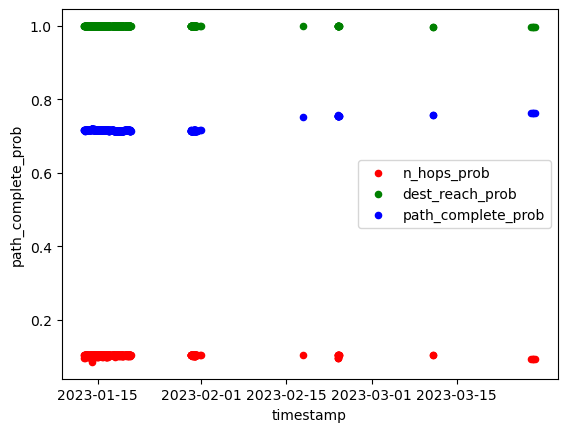

6810cb98  0.160%


n_hops_prob  dest_reach_prob  path_complete_prob     final
n_hops_prob            1.000000        -0.731800            0.548975 -0.692353
dest_reach_prob       -0.731800         1.000000           -0.851040  0.885354
path_complete_prob     0.548975        -0.851040            1.000000 -0.960346
final                 -0.692353         0.885354           -0.960346  1.000000

/home/msi/miniconda3/envs/stats/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1258: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


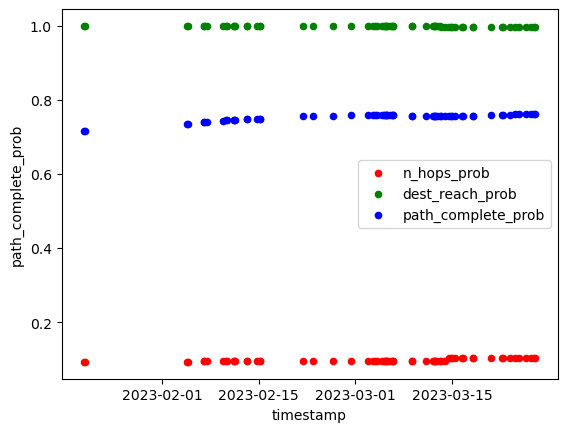

73e95713  36.166%


n_hops_prob  dest_reach_prob  path_complete_prob     final
n_hops_prob            1.000000         0.459051           -0.481161  0.607455
dest_reach_prob        0.459051         1.000000           -0.957552  0.761108
path_complete_prob    -0.481161        -0.957552            1.000000 -0.850073
final                  0.607455         0.761108           -0.850073  1.000000

/home/msi/miniconda3/envs/stats/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1258: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


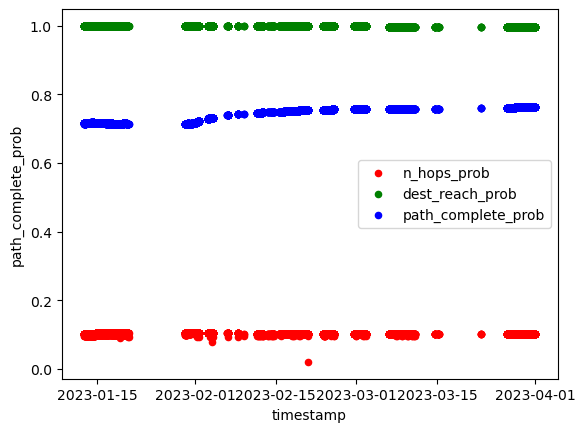

78bc5cec  1.603%


n_hops_prob  dest_reach_prob  path_complete_prob     final
n_hops_prob            1.000000         0.203216           -0.264957 -0.267926
dest_reach_prob        0.203216         1.000000           -0.901253 -0.933893
path_complete_prob    -0.264957        -0.901253            1.000000  0.993190
final                 -0.267926        -0.933893            0.993190  1.000000

/home/msi/miniconda3/envs/stats/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1258: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


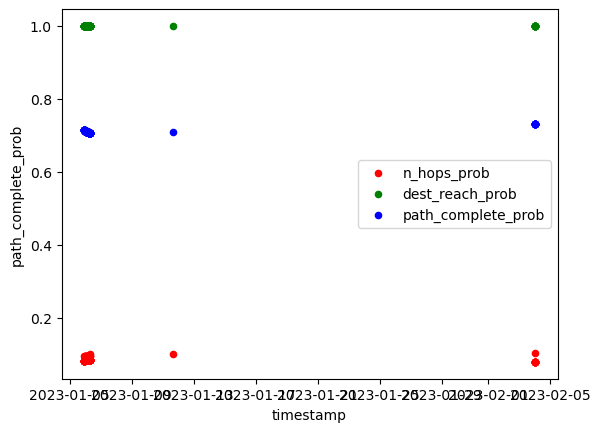

82ea5a74  0.060%


n_hops_prob  dest_reach_prob  path_complete_prob     final
n_hops_prob            1.000000        -0.347481            0.313362 -0.336000
dest_reach_prob       -0.347481         1.000000           -0.991261  0.997313
path_complete_prob     0.313362        -0.991261            1.000000 -0.996349
final                 -0.336000         0.997313           -0.996349  1.000000

/home/msi/miniconda3/envs/stats/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1258: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


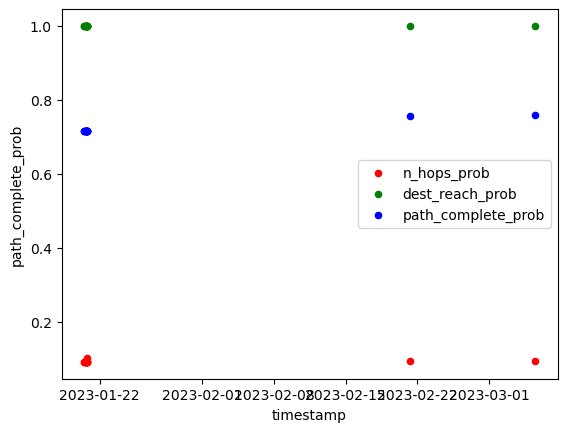

9aab4691  16.784%


n_hops_prob  dest_reach_prob  path_complete_prob     final
n_hops_prob            1.000000        -0.010960            0.596535 -0.902257
dest_reach_prob       -0.010960         1.000000           -0.324953 -0.004653
path_complete_prob     0.596535        -0.324953            1.000000 -0.637437
final                 -0.902257        -0.004653           -0.637437  1.000000

/home/msi/miniconda3/envs/stats/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1258: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


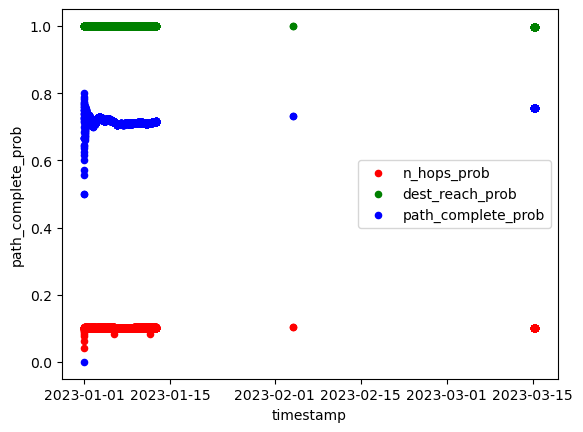

9da60b59  0.104%


n_hops_prob  dest_reach_prob  path_complete_prob     final
n_hops_prob            1.000000         1.000000            0.971185 -1.000000
dest_reach_prob        1.000000         1.000000            0.971204 -1.000000
path_complete_prob     0.971185         0.971204            1.000000 -0.971217
final                 -1.000000        -1.000000           -0.971217  1.000000

/home/msi/miniconda3/envs/stats/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1258: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


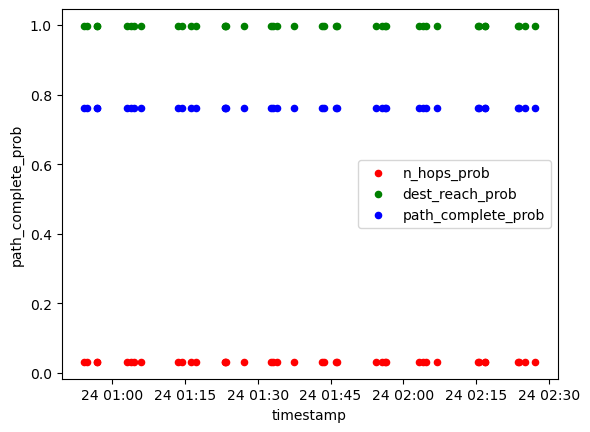

a354cabc  0.728%


n_hops_prob  dest_reach_prob  path_complete_prob     final
n_hops_prob            1.000000              NaN            0.198060  0.175027
dest_reach_prob             NaN              NaN                 NaN       NaN
path_complete_prob     0.198060              NaN            1.000000  0.970929
final                  0.175027              NaN            0.970929  1.000000

/home/msi/miniconda3/envs/stats/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1258: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


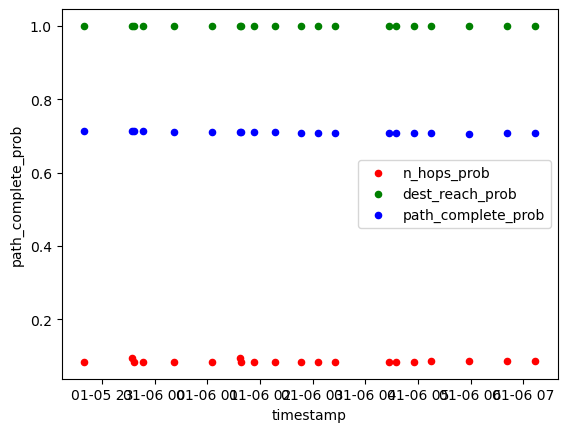

c6018267  0.033%


n_hops_prob  dest_reach_prob  path_complete_prob     final
n_hops_prob            1.000000          0.86603             0.86603 -0.866019
dest_reach_prob        0.866030          1.00000             1.00000 -1.000000
path_complete_prob     0.866030          1.00000             1.00000 -1.000000
final                 -0.866019         -1.00000            -1.00000  1.000000

/home/msi/miniconda3/envs/stats/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1258: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


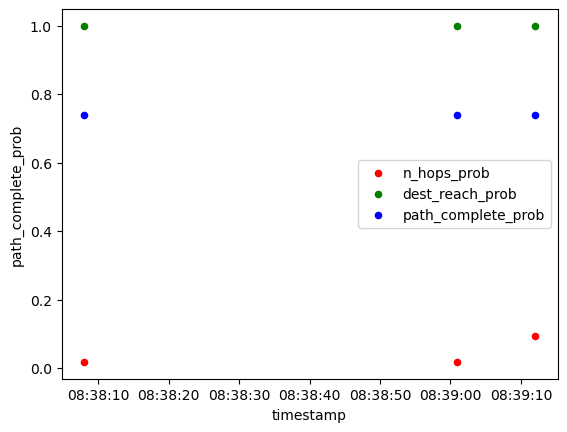

In [ ]:
for i, x in df.sort_values(by='asn_prob', ascending=False).groupby('asn'):
    if x.shape[0] < 3:
        continue
    print(i, f"{mm.category_probs[i]*100: .3f}%")
    display(x.select_dtypes(include=[int, float]).corr(method='pearson'))
    fig = plt.figure()
    x.plot(ax=plt.gca(), kind='scatter', x='timestamp', y='n_hops_prob', label='n_hops_prob', c='r')
    x.plot(ax=plt.gca(), kind='scatter', x='timestamp', y='dest_reach_prob', label='dest_reach_prob', c='g')
    x.plot(ax=plt.gca(), kind='scatter', x='timestamp', y='path_complete_prob', label='path_complete_prob', c='b')
    plt.show()

In [ ]:
df.select_dtypes(exclude=['object'], include=[float]).corr(method='pearson')

n_hops_prob  dest_reach_prob  path_complete_prob     final
n_hops_prob            1.000000         0.308957           -0.304899  0.011163
dest_reach_prob        0.308957         1.000000           -0.920338 -0.155193
path_complete_prob    -0.304899        -0.920338            1.000000  0.036219
final                  0.011163        -0.155193            0.036219  1.000000

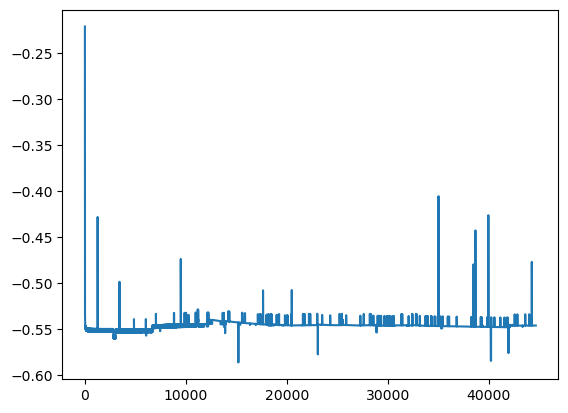

In [ ]:
plt.plot(final)

In [ ]:
final.shape[0]

44634

In [ ]:
from traced_v2.models.normal import NormalModel

In [ ]:
model = NormalModel("src", "dest", one_sided=True, sigma_0=1.5, mu_0=0, sigma_factor=4, gamma=0.5)

In [ ]:
for i, val in enumerate(final):
    model.log(i, val)

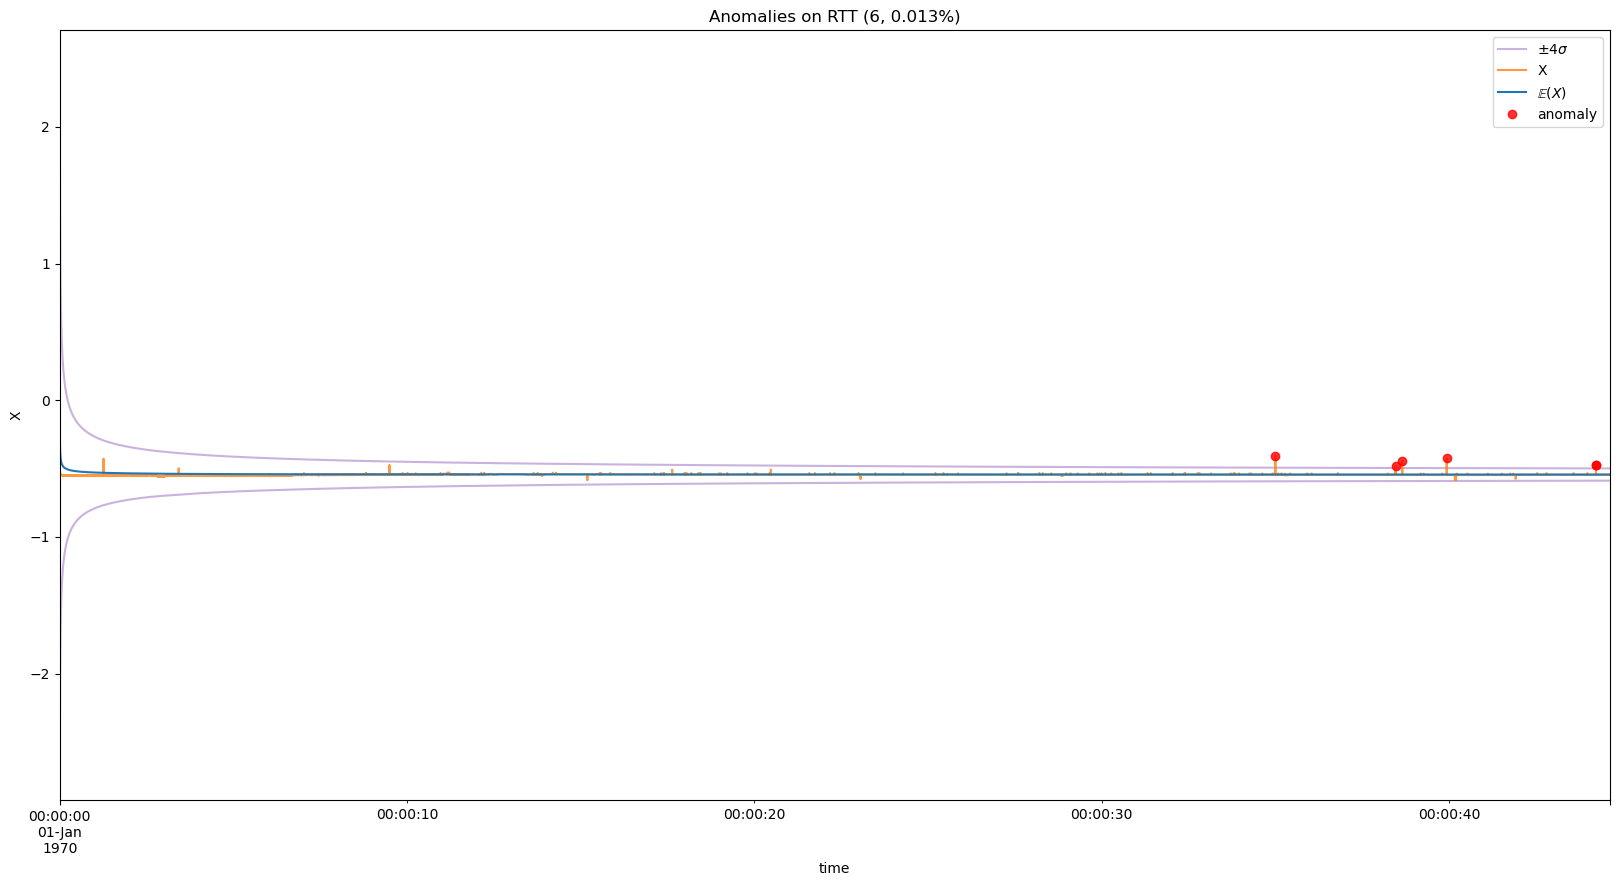

In [ ]:
fig = plt.figure(figsize=(20, 10))
model.plot()

In [ ]:
final = list(map(np.log1p, map(np.mean, final)))

In [ ]:
from scipy.stats import hmean

In [ ]:
final

array([-0.        , -0.10536052, -0.32315646, ..., -0.46553924,
       -0.46313564, -0.46553921])

In [ ]:
y= np.array(np.log1p(list(map(prod, ip_probs))))


In [ ]:
x = np.array(np.log1p(list(map(prod, asn_probs))))

In [ ]:
import pandas as pd

In [ ]:
tmp = pd.DataFrame(
    {'asn_prob': x, 'ip_prob': y, 'asn_hash': asn_hashes,  'length': n_hops, 'timestamp': timestamps, 'unique_asns': uniq_asn_hashes, 'final': final})


In [ ]:
tmp['asn_color'] = tmp['asn_hash'].astype('category')#.cat.codes

In [ ]:
tmp['unique_asns'] = tmp['unique_asns'].astype('category')#.cat.codes

In [ ]:
tmp['unique_asns_cat'] = tmp['unique_asns'].astype('category').cat.codes


In [ ]:
import seaborn as sns
sns.set_style("whitegrid")

In [ ]:
import plotly.graph_objects as go

In [ ]:
from traced_v2.models.normal import NormalModel

In [ ]:
model = NormalModel("src", "dest", one_sided=False, sigma_0=0.001, mu_0=0.2, sigma_factor=3, beta_0=0.05)

In [ ]:
for i, row in tmp.set_index('timestamp')['final'].items():
    model.log(i.timestamp()*1000, row)

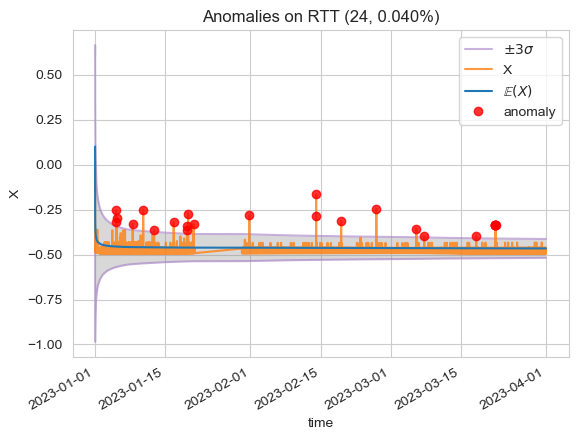

In [ ]:
model.plot()

In [ ]:
tmp['asn_prob_log'] = np.log1p(tmp['asn_prob'])

In [ ]:
tmp.plot(backend='plotly', y='asn_prob_log', x='timestamp', kind='scatter', color='asn_hash')

In [ ]:
import importlib

In [ ]:
from traced.models import MultinomialModel


In [ ]:
import traced

In [ ]:
traced.models = importlib.reload(traced.models)

In [ ]:
traced.models.multinomial_model = importlib.reload(traced.models.multinomial_model)

In [ ]:
from traced.models.multinomial_model import MultinomialModel

In [ ]:
mm = MultinomialModel("src", "dest")

In [ ]:
probs=[]
for i, x in tmp.set_index('timestamp')['asn_hash'].items():
   _,_, p =  mm.log(i, x)
   probs.append(p)

In [ ]:
tmp['asn_observed_prob'] = -np.log1p((probs))

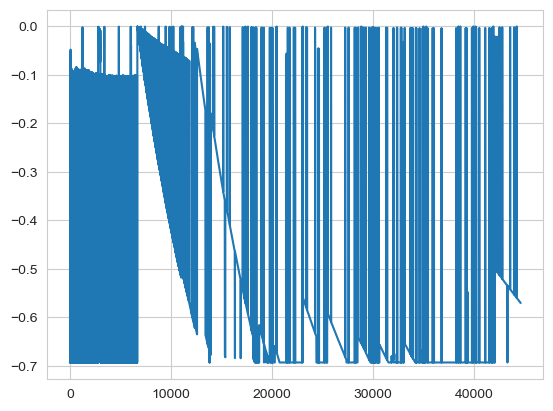

In [ ]:
plt.plot(tmp['asn_observed_prob'])

In [ ]:
tmp['prob_asn_prob'] = tmp.apply(lambda x: np.log1p(-x['asn_prob'] * x['asn_observed_prob'] ), axis=1)#.plot(kind='scatter')

In [ ]:
tmp.plot(backend='plotly', y='prob_asn_prob', x='timestamp', kind='scatter', color='asn_hash')

In [ ]:
nn = NormalModel("src", "dest", one_sided=True, sigma_0=1, mu_0=-0.2, sigma_factor=3, beta_0=.01, alpha_0=1)

In [ ]:
for i, x in tmp.set_index('timestamp')['prob_asn_prob'].items():
    nn.log(i.timestamp()*1000, x)

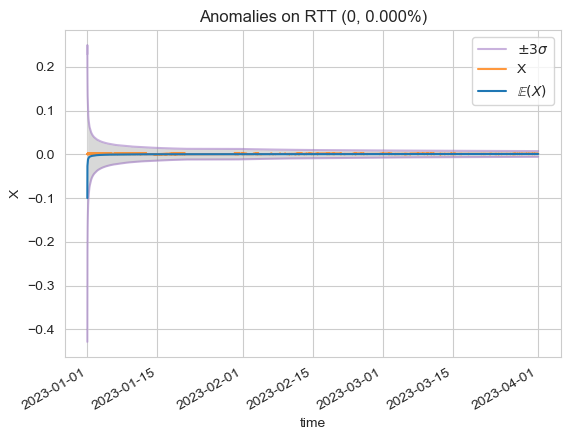

In [ ]:
nn.plot()